# Catboost with Tweedie Loss Function

In [188]:
import catboost as cb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from category_encoders.cat_boost import CatBoostEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


pd.set_option("mode.copy_on_write", True)

## Read the Dataset

In [189]:
df = pd.read_csv("data/InsNova_data_2023_train.csv")
df.head()

,id,veh_value,exposure,veh_body,veh_age,gender,area,agecat,engine_type,max_power,...,marital_status,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,high_education_ind,clm,numclaims,claimcst0
0,1,0.77,0.444504,SEDAN,4,M,D,3,petrol,147,...,S,1,weekday,6pm - 12am,6,640.448137,1.0,0,0,0.0
1,2,4.45,0.562183,STNWG,1,M,A,3,petrol,158,...,S,1,weekday,6am - 12pm,12,683.749691,0.0,0,0,0.0
2,3,4.90,0.465244,STNWG,1,F,A,3,petrol,159,...,M,1,weekday,6pm - 12am,6,653.656117,1.0,0,0,0.0
3,4,0.48,0.271039,PANVN,4,M,A,4,petrol,80,...,S,1,weekday,12pm - 6pm,12,642.574671,0.0,0,0,0.0
4,5,0.85,0.141624,SEDAN,4,F,A,5,petrol,126,...,S,0,weekday,6am - 12pm,6,647.175035,0.0,0,0,0.0


In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22619 entries, 0 to 22618
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     22619 non-null  int64  
 1   veh_value              22619 non-null  float64
 2   exposure               22619 non-null  float64
 3   veh_body               22619 non-null  object 
 4   veh_age                22619 non-null  int64  
 5   gender                 22619 non-null  object 
 6   area                   22619 non-null  object 
 7   agecat                 22619 non-null  int64  
 8   engine_type            22619 non-null  object 
 9   max_power              22619 non-null  int64  
 10  driving_history_score  22619 non-null  float64
 11  veh_color              22619 non-null  object 
 12  marital_status         22619 non-null  object 
 13  e_bill                 22619 non-null  int64  
 14  time_of_week_driven    22619 non-null  object 
 15  ti

<Axes: xlabel='claimcst0', ylabel='Count'>

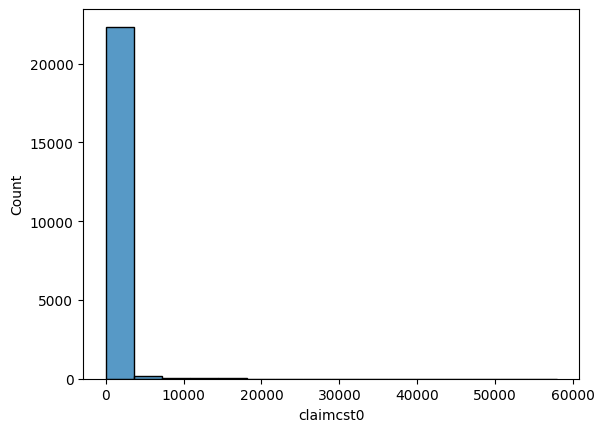

In [125]:
sns.histplot(data=df, x="claimcst0")

## DATA PREPROCESSING

In [191]:
df["high_education_ind"] = df["high_education_ind"].astype("int64")

In [193]:
categorical_features = [
    "veh_body",
    "veh_age",
    "gender",
    "area",
    "agecat",
    "engine_type",
    "veh_color",
    "marital_status",
    "time_of_week_driven",
    "time_driven",
    "e_bill",
    "trm_len",
    "high_education_ind",
]
for col in categorical_features:
    df[col] = df[col].astype("category")

In [129]:
X = df.drop(
    columns=[
        "id",
        "clm",
        "numclaims",
        "claimcst0",
    ]
)  # assuming 'claimcst0' is your target variable
y = df["claimcst0"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [132]:
from sklearn.metrics import make_scorer


def calculate_gini(y_train, y_test):
    df = pd.DataFrame({"Actual_Claim_Cost": y_train, "Predicted_Claim_Cost": y_test})
    df = df.sort_values(by="Predicted_Claim_Cost", ascending=False)
    df["Gini_Index"] = (
        df["Actual_Claim_Cost"].cumsum() / df["Actual_Claim_Cost"].sum()
    ) - np.arange(1, len(df) + 1) / len(df)
    return df["Gini_Index"].sum()


def normalized_gini(y_train, y_test):
    print(calculate_gini(y_train, y_test) / calculate_gini(y_train, y_train))
    return calculate_gini(y_train, y_test) / calculate_gini(y_train, y_train)


# Make a scorer with greater_is_better set to True since higher Gini values are better
# not needed just put here for reference later
gini_scorer = make_scorer(normalized_gini, greater_is_better=True)

## Grid Search for Best Parameters Using Normalized Gini Scorer

In [133]:
cat_model = cb.CatBoostRegressor(cat_features=categorical_features)

In [137]:
param_grid = {
    "depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05],
    "l2_leaf_reg": [4, 5, 6, 7, 8, 9],
    "iterations": [500, 1000, 1500],
    "logging_level": ["Silent"],
    "od_type": ["Iter"],
    "od_wait": [100],
    "loss_function": [
        "Tweedie:variance_power=1.1",
        "Tweedie:variance_power=1.2",
        "Tweedie:variance_power=1.3",
        "Tweedie:variance_power=1.4",
        "Tweedie:variance_power=1.5",
        "Tweedie:variance_power=1.6",
        "Tweedie:variance_power=1.7",
        "Tweedie:variance_power=1.8",
        "Tweedie:variance_power=1.9",
    ],
}

In [138]:
# Using Grid Search
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    cv=5,
    # scoring="neg_mean_squared_error",
    scoring=gini_scorer,
    n_jobs=-1,
)

# Or using Random Search
# random_search = RandomizedSearchCV(estimator=cat_model, param_distributions=param_grid, cv=5, scoring='neg_mean_squared_error', n_iter=50, random_state=42)

# Fit the model
grid_search.fit(X_train, y_train)

0.23823523010747383
0.27663292002513407
0.1395931526779878
0.2907839832815843
0.14478944197969248
0.22891972178485812
0.24064224296432243
0.14723500121164876
0.16156185354102012
0.09637541689428417
0.27818632448184755
0.10355386911065732
0.2857814264312832
0.29161153445737836
0.11493562138705149
0.12052593957708423
0.2503972370587483
0.1168024484068699
0.11759329688161912
0.09922352827710244
0.14911503982036042
0.2475794798809373
0.15442050299110235
0.1557109432170374
0.1039337564461462
0.3136421050316179
0.25682950655478365
0.28756000551004074
0.14523558021052876
0.14729274435201203
0.10168388955372784
0.25295056726348825
0.11610547241166702
0.09701992920697848
0.2236550658669266
0.11375494211508748
0.28197045211229077
0.1603630464201223
0.2808242424224263
0.11073985256173599
0.2046711417987687
0.10941610200937882
0.1244794951339965
0.16813662003974741
0.11779572919621818
0.2725623174456025
0.2739896732641348
0.11733019022545654
0.11079107708835567
0.17334916267312617
0.14030407644448

/Users/jeremytan/miniconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



0.09007486632910579
0.2969234544431693
0.09842646861588891
0.16056584068311425
0.18387412619576207
0.1690197472205758
0.23993284586224994
0.21476122609261158
0.263838141206108
0.12247067976027096
0.11225488796136888
0.24455327299779883
0.0864554080776675
0.25901435175900783
0.14749486193561226
0.1284530365454142
0.2502341595820108
0.09372902054650759
0.17390662033531376
0.26588620983971356
0.16701500091578947
0.13282676220481923
0.29075717472157564
0.1137657220495456
0.09827761504348119
0.2603253474611419
0.09790854849081142
0.26960431153074926
0.16900007781486187
0.12652693036510668
0.2343780747558274
0.09828580898040101
0.23878319774887996
0.23803015057029756
0.12585918344791638
0.1464400858267551
0.1095737421705487
0.16746306986065296
0.22368342813445485
0.14213772110983297
0.222493789664246
0.07794382249235153
0.1965264357757731
0.2414303794617227
0.1157927067873308
0.12493632493194495
0.09563134488795286
0.1273373848321475
0.28113581640137936
0.15998184226503046
0.2396652995843185

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x2d7618150>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8, 10],
                         'iterations': [500, 1000, 1500],
                         'l2_leaf_reg': [4, 5, 6, 7, 8, 9],
                         'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],
                         'logging_level': ['Silent'],
                         'loss_function': ['Tweedie:variance_power=1.1',
                                           'Tweedie:variance_power=1.2',
                                           'Tweedie:variance_power=1.3',
                                           'Tweedie:variance_power=1.4',
                                           'Tweedie:variance_power=1.5',
                                           'Tweedie:variance_power=1.6',
                                           'Tweedie:variance_power=1.7',
                                           'Tweedie:variance_power=1.8',
                                           'Tweedie:variance_power=1.9'],
                         'od_type': ['Iter'], 'od_wait': [100]},
             scoring=make_scorer(normalized_gini))

In [139]:
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Evaluate the best model
best_model = grid_search.best_estimator_
best_model.score(X_test, y_test)  # You can use other metrics as needed

# Get the best score
best_score = grid_search.best_score_
print(f"Best Score: {best_score}")

Best parameters: {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 8, 'learning_rate': 0.02, 'logging_level': 'Silent', 'loss_function': 'Tweedie:variance_power=1.3', 'od_type': 'Iter', 'od_wait': 100}
Best Score: 0.20809451312347504


In [41]:
print(best_model)

In [149]:
x_train = df.drop(
    columns=[
        "id",
        "clm",
        "numclaims",
        "claimcst0",
        # "veh_age",
        # "gender",
        # "area",
        # "agecat",
        # "engine_type",
        # "veh_color",
        # "marital_status",
        # "time_of_week_driven",
        # "time_driven",
        # "e_bill",
        # "trm_len",
        # "high_education_ind",
        # "max_power",
        # "veh_body",
    ]
)
y_train = df["claimcst0"]

In [150]:
train_data = Pool(data=x_train, label=y_train, cat_features=categorical_features)

## Fit Model with Best Parameters Found

In [151]:
# Best parameters: {'depth': 8, 'iterations': 500, 'learning_rate': 0.03, 'logging_level': 'Silent', 'loss_function': 'Tweedie:variance_power=1.2', 'od_type': 'Iter', 'od_wait': 150}
# Best parameters: {'depth': 3, 'iterations': 1000, 'learning_rate': 0.01, 'logging_level': 'Silent', 'loss_function': 'Tweedie:variance_power=1.5'}
# Best parameters: {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 8, 'learning_rate': 0.02, 'logging_level': 'Silent', 'loss_function': 'Tweedie:variance_power=1.3', 'od_type': 'Iter', 'od_wait': 100}

model = CatBoostRegressor(
    iterations=1000,
    depth=6,
    learning_rate=0.02,
    loss_function="Tweedie:variance_power=1.3",
    l2_leaf_reg=8,
)

# Train the regression model
model.fit(train_data)

0:	learn: 534.4432367	total: 9.72ms	remaining: 9.71s
1:	learn: 524.1843182	total: 15.2ms	remaining: 7.58s
2:	learn: 514.1432752	total: 22.3ms	remaining: 7.41s
3:	learn: 504.3168088	total: 34.4ms	remaining: 8.57s
4:	learn: 494.7005758	total: 43.8ms	remaining: 8.72s
5:	learn: 485.2918247	total: 47.3ms	remaining: 7.84s
6:	learn: 476.0863363	total: 53ms	remaining: 7.51s
7:	learn: 467.0814922	total: 58.1ms	remaining: 7.21s
8:	learn: 458.2727557	total: 62.1ms	remaining: 6.84s
9:	learn: 449.6592442	total: 65.5ms	remaining: 6.49s
10:	learn: 441.2361254	total: 70.3ms	remaining: 6.32s
11:	learn: 433.0015533	total: 72.3ms	remaining: 5.96s
12:	learn: 424.9493842	total: 76.7ms	remaining: 5.82s
13:	learn: 417.0818387	total: 79.2ms	remaining: 5.58s
14:	learn: 409.3935358	total: 81.1ms	remaining: 5.32s
15:	learn: 401.8818894	total: 86.4ms	remaining: 5.31s
16:	learn: 394.5430497	total: 90.6ms	remaining: 5.24s
17:	learn: 387.3773372	total: 94.6ms	remaining: 5.16s
18:	learn: 380.3809151	total: 97.7ms	rem

## Feature Selection

In [143]:
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm

# Assuming x_train, y_train are your features and labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Best parameters: {'depth': 3, 'iterations': 500, 'learning_rate': 0.01, 'logging_level': 'Silent', 'loss_function': 'Tweedie:variance_power=1.2'}


# Assuming categorical_features is a list of indices or names of categorical features
train_data_features = Pool(
    data=X_train, label=y_train, cat_features=categorical_features
)
test_data_features = Pool(data=X_test, label=y_test, cat_features=categorical_features)
print(X_train.info())


def select_features(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print("Algorithm:", algorithm)
    model = CatBoostRegressor(
        iterations=1000,
        depth=6,
        learning_rate=0.02,
        loss_function="Tweedie:variance_power=1.3",
        l2_leaf_reg=8,
    )
    summary = model.select_features(
        train_data_features,
        eval_set=test_data_features,
        features_for_select=list(range(train_data_features.num_col())),
        num_features_to_select=15,
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level="Silent",
        plot=True,
    )
    print("Selected features:", summary["selected_features_names"])
    return summary

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18095 entries, 9555 to 15795
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   veh_value              18095 non-null  float64 
 1   exposure               18095 non-null  float64 
 2   veh_body               18095 non-null  category
 3   veh_age                18095 non-null  category
 4   gender                 18095 non-null  category
 5   area                   18095 non-null  category
 6   agecat                 18095 non-null  category
 7   engine_type            18095 non-null  category
 8   max_power              18095 non-null  int64   
 9   driving_history_score  18095 non-null  float64 
 10  veh_color              18095 non-null  category
 11  marital_status         18095 non-null  category
 12  e_bill                 18095 non-null  category
 13  time_of_week_driven    18095 non-null  category
 14  time_driven            18095 non-nu

In [144]:
invs_shap_summary = select_features(
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=3
)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['exposure', 'veh_body', 'veh_age', 'area', 'agecat', 'engine_type', 'max_power', 'driving_history_score', 'veh_color', 'marital_status', 'e_bill', 'time_of_week_driven', 'time_driven', 'trm_len', 'high_education_ind']


In [145]:
_ = select_features(
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=9
)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


The number of features selection steps (9) is greater than the number of features to eliminate (3). The number of steps was reduced to 3.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['exposure', 'veh_body', 'veh_age', 'area', 'agecat', 'engine_type', 'max_power', 'driving_history_score', 'veh_color', 'marital_status', 'e_bill', 'time_of_week_driven', 'time_driven', 'trm_len', 'high_education_ind']


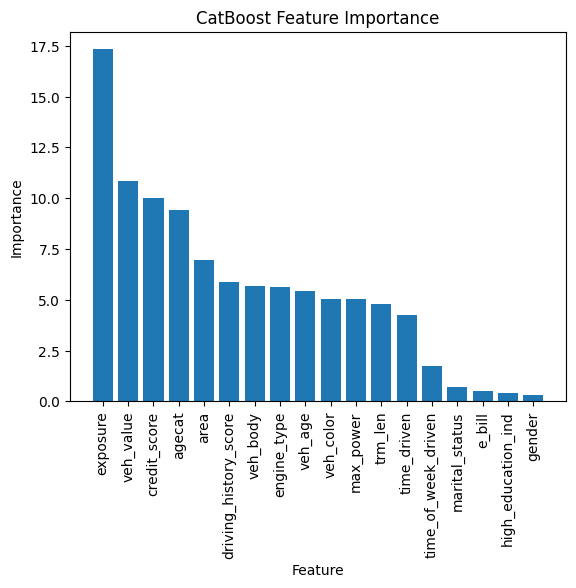

In [152]:
import matplotlib.pyplot as plt

feature_importance = model.get_feature_importance()
feature_names = x_train.columns


# Sort feature importance in descending order
sorted_idx = feature_importance.argsort()[::-1]

# Plot the features and their importances
plt.bar(range(len(feature_names)), feature_importance[sorted_idx])
plt.xticks(
    range(len(feature_names)),
    [feature_names[i] for i in sorted_idx],
    rotation="vertical",
)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("CatBoost Feature Importance")
plt.show()

In [ ]:
# Selected features: ['exposure', 'veh_age', 'area', 'agecat', 'veh_color', 'marital_status', 'time_driven', 'trm_len', 'high_education_ind']

In [194]:
# Best parameters: {'depth': 3, 'iterations': 500, 'learning_rate': 0.01, 'logging_level': 'Silent', 'loss_function': 'Tweedie:variance_power=1.2'}
# Best parameters: {'depth': 3, 'iterations': 1000, 'learning_rate': 0.01, 'logging_level': 'Silent', 'loss_function': 'Tweedie:variance_power=1.5'}
x_train = df.drop(
    columns=[
        "id",
        "clm",
        "numclaims",
        "claimcst0",
        # "veh_age",
        # "gender",
        # "area",
        # "agecat",
        # "engine_type",
        # "veh_color",
        # "marital_status",
        # "time_of_week_driven",
        # "time_driven",
        # "e_bill",
        # "trm_len",
        # "high_education_ind",
        # "max_power",
        # "veh_body",
    ]
)
y_train = df["claimcst0"]

In [195]:
cat_changed = [
    "veh_age",
    "area",
    "agecat",
    "trm_len",
    "high_education_ind",
    "gender",
    "time_of_week_driven",
]
train_data = Pool(data=x_train, label=y_train, cat_features=categorical_features)

In [199]:
# Best parameters: {'depth': 3, 'iterations': 500, 'learning_rate': 0.01, 'logging_level': 'Silent', 'loss_function': 'Tweedie:variance_power=1.2'}
# Best parameters: {'depth': 3, 'iterations': 1000, 'learning_rate': 0.01, 'logging_level': 'Silent', 'loss_function': 'Tweedie:variance_power=1.5'}

model = CatBoostRegressor(
    iterations=1000,
    depth=3,
    learning_rate=0.01,
    loss_function="Tweedie:variance_power=1.5",
)
model.fit(train_data)

0:	learn: 324.9106558	total: 3.96ms	remaining: 3.95s
1:	learn: 321.7576365	total: 9.75ms	remaining: 4.87s
2:	learn: 318.6367427	total: 13.6ms	remaining: 4.53s
3:	learn: 315.5477057	total: 16.9ms	remaining: 4.2s
4:	learn: 312.4902107	total: 20ms	remaining: 3.99s
5:	learn: 309.4639121	total: 23.5ms	remaining: 3.89s
6:	learn: 306.4685665	total: 26.5ms	remaining: 3.76s
7:	learn: 303.5038626	total: 29.6ms	remaining: 3.67s
8:	learn: 300.5693142	total: 32.7ms	remaining: 3.6s
9:	learn: 297.6649170	total: 35.4ms	remaining: 3.51s
10:	learn: 294.7900799	total: 38.2ms	remaining: 3.43s
11:	learn: 291.9449171	total: 39.7ms	remaining: 3.26s
12:	learn: 289.1288658	total: 42.4ms	remaining: 3.22s
13:	learn: 286.3417561	total: 44.5ms	remaining: 3.13s
14:	learn: 283.5832094	total: 47.5ms	remaining: 3.12s
15:	learn: 280.8529469	total: 50ms	remaining: 3.08s
16:	learn: 278.1508108	total: 53.4ms	remaining: 3.08s
17:	learn: 275.4764986	total: 56ms	remaining: 3.06s
18:	learn: 272.8296768	total: 57.4ms	remaining

In [200]:
# Best parameters: {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 8, 'learning_rate': 0.02, 'logging_level': 'Silent', 'loss_function': 'Tweedie:variance_power=1.3', 'od_type': 'Iter', 'od_wait': 100}
predictions = []


model = CatBoostRegressor(
    iterations=1000,
    depth=3,
    learning_rate=0.01,
    loss_function="Tweedie:variance_power=1.5",
)
model.fit(train_data)
y_pred = model.predict(x_train)
print(y_pred)

0:	learn: 324.9106558	total: 4.82ms	remaining: 4.82s
1:	learn: 321.7576365	total: 9.79ms	remaining: 4.89s
2:	learn: 318.6367427	total: 14.2ms	remaining: 4.71s
3:	learn: 315.5477057	total: 18.6ms	remaining: 4.63s
4:	learn: 312.4902107	total: 21.6ms	remaining: 4.31s
5:	learn: 309.4639121	total: 26.1ms	remaining: 4.32s
6:	learn: 306.4685665	total: 29.6ms	remaining: 4.2s
7:	learn: 303.5038626	total: 34.2ms	remaining: 4.25s
8:	learn: 300.5693142	total: 37.4ms	remaining: 4.12s
9:	learn: 297.6649170	total: 40.3ms	remaining: 3.99s
10:	learn: 294.7900799	total: 43.2ms	remaining: 3.88s
11:	learn: 291.9449171	total: 44.5ms	remaining: 3.67s
12:	learn: 289.1288658	total: 47ms	remaining: 3.57s
13:	learn: 286.3417561	total: 49.2ms	remaining: 3.47s
14:	learn: 283.5832094	total: 52.2ms	remaining: 3.42s
15:	learn: 280.8529469	total: 54.5ms	remaining: 3.35s
16:	learn: 278.1508108	total: 57.8ms	remaining: 3.34s
17:	learn: 275.4764986	total: 60.3ms	remaining: 3.29s
18:	learn: 272.8296768	total: 61.6ms	rema

## Prediction and Submission

In [197]:
test = pd.read_csv("data/InsNova_data_2023_vh.csv")
test["high_education_ind"] = test["high_education_ind"].astype("int64")
for col in categorical_features:
    test[col] = test[col].astype("category")

In [204]:
x_test = test.drop(
    columns=[
        "id",
    ]
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22620 entries, 0 to 22619
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   veh_value              22620 non-null  float64 
 1   exposure               22620 non-null  float64 
 2   veh_body               22620 non-null  category
 3   veh_age                22620 non-null  category
 4   gender                 22620 non-null  category
 5   area                   22620 non-null  category
 6   agecat                 22620 non-null  category
 7   engine_type            22620 non-null  category
 8   max_power              22620 non-null  int64   
 9   driving_history_score  22620 non-null  int64   
 10  veh_color              22620 non-null  category
 11  marital_status         22620 non-null  category
 12  e_bill                 22620 non-null  category
 13  time_of_week_driven    22620 non-null  category
 14  time_driven            22620 non-null 

In [186]:
# bagging shouldnt be an issue with bias just helps decrease variance
predictions = []
# Best parameters: {'depth': 8, 'iterations': 500, 'learning_rate': 0.03, 'logging_level': 'Silent', 'loss_function': 'Tweedie:variance_power=1.2', 'od_type': 'Iter', 'od_wait': 150}


# bagging
for i in range(1):
    model = CatBoostRegressor(
        iterations=1000,
        depth=6,
        learning_rate=0.02,
        loss_function="Tweedie:variance_power=1.9999999",
        l2_leaf_reg=8,
        random_seed=i,
        logging_level="Silent",
    )
    model.fit(train_data)
    y_pred = model.predict(x_test)
    predictions.append(y_pred)

prediction = np.mean(predictions, axis=0)
print(len(prediction))

22620


In [187]:
test["Predict"] = prediction

submission = test[["id", "Predict"]]
submission

,id,Predict
0,1,12.304717
1,2,18.585140
2,3,41.255039
3,4,140.889501
4,5,55.462979
...,...,...
22615,22616,1.286987
22616,22617,1.145830
22617,22618,118.151192
22618,22619,146.035882


In [178]:
submission.to_csv("catboost_submission_all_bagging.csv", index=False)